In [26]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import (display, Markdown as md)

### Load the data

In [27]:
# Use gviz/tq?tqx=out:csv magic to access the google sheets data.

column_names = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
column_dtypes = defaultdict(lambda: np.float64)
column_dtypes['date'] = 'str'

sp500_url = f"https://docs.google.com/spreadsheets/d/1eVUW33mivgbwzsoTiuWYhGklOIdpmoIlvelmKkt_pjs/gviz/tq?tqx=out:csv&sheet=s&p500"
tsla_url = f"https://docs.google.com/spreadsheets/d/1eVUW33mivgbwzsoTiuWYhGklOIdpmoIlvelmKkt_pjs/gviz/tq?tqx=out:csv&sheet=tsla"
sp500 = pd.read_csv(sp500_url, header=0, names=column_names, dtype=column_dtypes, parse_dates=[0])
tsla = pd.read_csv(tsla_url, header=0, names=column_names, dtype=column_dtypes, parse_dates=[0])

sp500 = sp500.sort_values(by='date')
tsla = tsla.sort_values(by='date')

sp500.set_index('date', inplace=True, drop=False)
tsla.set_index('date', inplace=True, drop=False)

sp500.volume = sp500.volume.rolling('30d').mean()
tsla.volume = tsla.volume.rolling('30d').mean()

In [28]:
def changes_from_date(df, start_date='1970-01-01', end_date='2036-01-01'):
    baseline = df.loc[start_date:].iloc[0]
    newdf = df.loc[start_date:end_date].copy()
    newdf['xopen'] = 100 * (newdf.open - baseline.open) / baseline.open
    newdf['xhigh'] = 100 * (newdf.high - baseline.high) / baseline.high
    newdf['xlow'] = 100 * (newdf.low - baseline.low) / baseline.low
    newdf['xclose'] = 100 * (newdf.close - baseline.close) / baseline.close
    newdf['xadj_close'] = 100 * (newdf.adj_close - baseline.adj_close) / baseline.adj_close
    newdf['xvolume'] = 100 * (newdf.volume - baseline.volume) / baseline.volume
    return newdf

### Plot

In [61]:
start_date = '2012-01-01'
end_date = '2023-01-01'
min_hold_days = pd.to_timedelta(30, unit='d')
max_hold_days = pd.to_timedelta(1000, unit='d')

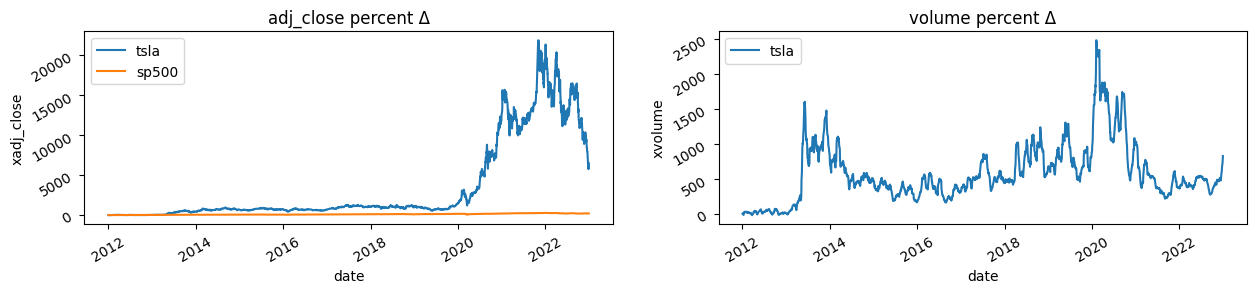

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2.5))
fig.subplots_adjust(hspace=0.5)

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
# fig.subplots_adjust(hspace=0.5)

ax1.tick_params(rotation=30)
ax1.set_title('adj_close percent Δ')
sns.lineplot(ax=ax1, x='date', y='xadj_close', label='tsla', data=changes_from_date(tsla, start_date, end_date))
sns.lineplot(ax=ax1, x='date', y='xadj_close', label='sp500', data=changes_from_date(sp500, start_date, end_date))
sns.move_legend(ax1, "upper left", bbox_to_anchor=(0, 1))

ax2.tick_params(rotation=30)
ax2.set_title('volume percent Δ')
sns.lineplot(ax=ax2, x='date', y='xvolume', label='tsla', data=changes_from_date(tsla, start_date, end_date))
# sns.lineplot(ax=ax2, x='date', y='xvolume', label='sp500', data=changes_from_date(sp500, start_date, end_date))
sns.move_legend(ax2, "upper left", bbox_to_anchor=(0, 1))


### Generate and analyze all possible buy/sell pairs.

In [63]:
tsla_pairs = pd.merge(tsla.loc[start_date:end_date], tsla.loc[start_date:end_date], how='cross')
tsla_pairs = tsla_pairs[(tsla_pairs.date_y - tsla_pairs.date_x < max_hold_days) &
                        (tsla_pairs.date_y - tsla_pairs.date_x > min_hold_days)]
tsla_pairs['earnings'] = (tsla_pairs.adj_close_y - tsla_pairs.adj_close_x) / tsla_pairs.adj_close_x

sp500_pairs = pd.merge(sp500.loc[start_date:end_date], sp500.loc[start_date:end_date], how='cross')
sp500_pairs = sp500_pairs[(sp500_pairs.date_y - sp500_pairs.date_x < max_hold_days) &
                          (sp500_pairs.date_y - sp500_pairs.date_x > min_hold_days)]
sp500_pairs['earnings'] = (sp500_pairs.adj_close_y - sp500_pairs.adj_close_x) / sp500_pairs.adj_close_x

tsla_loss_probability = 100 * tsla_pairs[tsla_pairs.adj_close_x > tsla_pairs.adj_close_y].shape[0] / tsla_pairs.shape[0]
sp500_loss_probability = 100 * sp500_pairs[sp500_pairs.adj_close_x > sp500_pairs.adj_close_y].shape[0] / sp500_pairs.shape[0]

md(
    f'* tsla_loss_probability = {tsla_loss_probability:.2f}%\n'
    f'* tsla earning per dollar = {tsla_pairs.earnings.mean():.2f}\n'
    f'* sp500_loss_probability = {sp500_loss_probability:.2f}%\n'
    f'* sp500 earning per dollar = {sp500_pairs.earnings.mean():.2f}'
)

* tsla_loss_probability = 24.64%
* tsla earning per dollar = 2.00
* sp500_loss_probability = 11.15%
* sp500 earning per dollar = 0.17

In [64]:
tsla_pairs[(tsla_pairs.date_x < '2012-01-10') &
           (tsla_pairs.date_y < '2012-01-10') &
           (tsla_pairs.date_x + min_hold_days < tsla_pairs.date_y)]

,date_x,open_x,high_x,low_x,close_x,adj_close_x,volume_x,date_y,open_y,high_y,low_y,close_y,adj_close_y,volume_y,earnings
